In [ ]:
%load_ext autoreload
%autoreload 2

from typing import Any

from causalab.tasks.MCQA.causal_models import positional_causal_model
from causalab.tasks.MCQA.counterfactuals import (
    different_symbol,
    same_symbol_different_position,
    random_counterfactual,
)
from causalab.causal.counterfactual_dataset import CounterfactualExample

from causalab.neural.pipeline import LMPipeline
import torch

causal_model = positional_causal_model

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "meta-llama/Llama-3.2-1B-Instruct"
pipeline = LMPipeline(
    model_name,
    max_new_tokens=1,
    device=device,
    dtype=torch.bfloat16 if device == "cuda" else torch.float32,
    max_length=32,
)


def metric(neural_output: dict[str, Any], causal_output: str) -> bool:
    return (
        causal_output in neural_output["string"]
        or neural_output["string"] in causal_output
    )

# Localizing the Answer and Answer Position Variables 

In the second notebook, the tracing experiments provide a window into the computational process underlying the LMs ability to correctly answer a single multiple choice question. 
Now, we will move on to a setting where we have a full dataset of original-counterfactual input pairs that we can use to compute the average effects of interventions. 
We will start by using the counterfactual datasets from the first notebook. 

In [2]:
from causalab.experiments.filter import filter_dataset

# Generate datasets
size = 64

# Set up counterfactual generators
counterfactual_generators = {
    "different_symbol": different_symbol,
    "same_symbol_different_position": same_symbol_different_position,
    "random_counterfactual": random_counterfactual,
}

# Generate counterfactual datasets (now just lists of CounterfactualExample)
print("Generating counterfactual datasets...")
counterfactual_datasets: dict[str, list[CounterfactualExample]] = {}
for name, sampler in counterfactual_generators.items():
    counterfactual_datasets[name] = [sampler() for _ in range(size)]
    print(f"  {name}: {len(counterfactual_datasets[name])} examples")

# Filter datasets
print("\nFiltering datasets...")
filtered_datasets: dict[str, list[CounterfactualExample]] = {}
for name, dataset in counterfactual_datasets.items():
    filtered_datasets[name] = filter_dataset(
        dataset=dataset,
        pipeline=pipeline,
        causal_model=causal_model,
        metric=metric,
        batch_size=128,
    )

different_symbol_pairs = filtered_datasets["different_symbol"]
same_symbol_diff_position_pairs = filtered_datasets["same_symbol_different_position"]
random_pairs = filtered_datasets["random_counterfactual"]

print(f"\n✓ Generated {len(counterfactual_datasets)} datasets")
print(f"✓ Filtered to {sum(len(d) for d in filtered_datasets.values())} total examples")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Generating counterfactual datasets...
  different_symbol: 64 examples
  same_symbol_different_position: 64 examples
  random_counterfactual: 64 examples

Filtering datasets...

✓ Generated 3 datasets
✓ Filtered to 174 total examples


## Filtering the Counterfactual Datasets

This step is not necessary for a causal abstraction analysis, as we can construct a high-level causal model of a neural network's failure cases as well as its success cases. However, for our running example with this small Llama model that performs poorly on the task, we will filter to a dataset the model performs well on.

## Token Positions

We are aggregating the results of activation patching across many interchange interventions, and to target our analysis we focus on a small number of token positions that we saw were important in the tracing experiments ran in the second notebook. Moreover, the random counterfactuals might have symbols at different indices, because the number of tokens in the question can vary based on how many tokens are needed for objects and colors. 

The token position objects allow for a dynamic notion of position. We use this in defining the correct_symbol token positions, which will be the first or the second symbol depending on the input.

In [3]:
from causalab.tasks.MCQA.token_positions import create_token_positions

all_token_positions = create_token_positions(pipeline)

# Order token positions with last_token at the end
ordered_position_names = [
    "correct_symbol",
    "correct_symbol_period",
    "symbol0",
    "symbol0_period",
    "symbol1",
    "symbol1_period",
    "last_token",
]

token_positions = [all_token_positions[name] for name in ordered_position_names]

for token_position in token_positions:
    print(f"\nToken position: {token_position.id}")
    example = next(iter(counterfactual_datasets.values()))[0]["input"]
    print(f"Selected token: {token_position.highlight_selected_token(example)}")


Token position: correct_symbol
Selected token: <|begin_of_text|>The bag is pink. What color is the bag?
S. orange
**L**. pink
Answer:

Token position: correct_symbol_period
Selected token: <|begin_of_text|>The bag is pink. What color is the bag?
S. orange
L**.** pink
Answer:

Token position: symbol0
Selected token: <|begin_of_text|>The bag is pink. What color is the bag?
**S**. orange
L. pink
Answer:

Token position: symbol0_period
Selected token: <|begin_of_text|>The bag is pink. What color is the bag?
S**.** orange
L. pink
Answer:

Token position: symbol1
Selected token: <|begin_of_text|>The bag is pink. What color is the bag?
S. orange
**L**. pink
Answer:

Token position: symbol1_period
Selected token: <|begin_of_text|>The bag is pink. What color is the bag?
S. orange
L**.** pink
Answer:

Token position: last_token
Selected token: <|begin_of_text|>The bag is pink. What color is the bag?
S. orange
L. pink
Answer**:**


# Activation Patching with Counterfactual Datasets

We will now conduct an experiment where we perform interchange interventions on the entire residual stream vector of each token position, at each layer, with each counterfactual dataset. 

The central idea of causal abstraction analysis is that a causal model is a faithful description of a neural network to the degree that interchange interventions on the variables in the causal model have equivalent effects to the same interchange interventions on the hidden vectors in a neural network. The proportion of interchange interventions that produce the same effect on the causal model and neural network is a metric known as **Interchange Intervention Accuracy**. 

After we perform the interchange interventions on the language model and collect the results, we will use the causal model to interpret the results and reveal the answer and answer pointer variables in the network.

In [4]:
from causalab.experiments.jobs.interchange_score_grid import (
    run_interchange_score_heatmap,
)
from causalab.experiments.interchange_targets import build_residual_stream_targets
from causalab.causal.causal_utils import save_counterfactual_examples
import os

# Create output directories
results_dir = "vector_patching_results"
os.makedirs(results_dir, exist_ok=True)

# Save filtered datasets to disk for the patching function
temp_datasets_dir = "./temp_filtered_datasets"
os.makedirs(temp_datasets_dir, exist_ok=True)

# Define layers to analyze
num_layers = pipeline.model.config.num_hidden_layers
layers = [-1] + list(range(num_layers))

# Run patching for each dataset
results: dict[str, dict[str, Any]] = {}


def patch_dataset(dataset_name: str) -> None:
    print(f"\n{'=' * 80}")
    print(f"Processing dataset: {dataset_name}")
    print(f"{'=' * 80}")
    dataset = filtered_datasets[dataset_name]

    # Save dataset temporarily as JSON
    dataset_path = os.path.join(temp_datasets_dir, f"{dataset_name}.json")
    save_counterfactual_examples(dataset, dataset_path)

    # Create output directory for this dataset
    dataset_output_dir = os.path.join(results_dir, dataset_name)

    # Build interchange targets for residual stream
    targets = build_residual_stream_targets(
        pipeline=pipeline,
        layers=layers,
        token_positions=token_positions,
        mode="one_target_per_unit",
    )

    # Run patching experiment
    result = run_interchange_score_heatmap(
        causal_model=causal_model,
        interchange_targets=targets,
        dataset_path=dataset_path,
        pipeline=pipeline,
        batch_size=128,
        target_variable_groups=[("answer",), ("answer_position",)],
        output_dir=dataset_output_dir,
        metric=metric,
        verbose=True,
    )

    # Store results in format compatible with visualization cells
    results[dataset_name] = {
        str(("answer",)): result["scores"][("answer",)],
        str(("answer_position",)): result["scores"][("answer_position",)],
    }


print("\nInterventions complete and scores computed!")


Interventions complete and scores computed!


## Different Symbol Counterfactual Results (Localizing the Answer)

The different_symbol counterfactuals where designed to localize the output variable of the causal model, i.e., localize the next token prediction made by the LM.
The pairs are similar to those we used for our tracing experiment, where we randomly sample a new symbol:

In [5]:
print(different_symbol_pairs[0])
print("Original input:")
print(different_symbol_pairs[0]["input"]["raw_input"])
print("\nCounterfactual input:")
print(different_symbol_pairs[0]["counterfactual_inputs"][0]["raw_input"])

{'input': <causalab.causal.trace.CausalTrace object at 0x150745d20>, 'counterfactual_inputs': [<causalab.causal.trace.CausalTrace object at 0x150745ed0>]}
Original input:
The bag is pink. What color is the bag?
S. orange
L. pink
Answer:

Counterfactual input:
The bag is pink. What color is the bag?
Q. orange
P. pink
Answer:



This dataset can distinguish the answer variable from the answer position variable and no intervention (see the first notebook for a more extended explanation). 

Observe that the answer token is localized to the first layer of the residual stream above the correct_symbol token, because that input token perfectly determines the output token. 
After two layers, it appears that signal is moved somewhat to the period token.

Because the correct symbol is randomly in the first or second positions, the variable cannot be reliably localized there. However, there is asymmetry in that the signal above the first symbol token is weaker than the signal above the second symbol token.

In [6]:
# Check what the causal model can distinguish with this dataset
print(
    causal_model.can_distinguish_with_dataset(different_symbol_pairs, ["answer"], None)
)
print(
    causal_model.can_distinguish_with_dataset(
        different_symbol_pairs, ["answer"], ["answer_position"]
    )
)

{'proportion': 1.0, 'count': 60}
{'proportion': 1.0, 'count': 60}


This dataset confounds the answer_position variable with no intervention, meaning interchange intervention accuracy on this dataset is perfect when the model output doesn't change.  
This results in all of the causally irrelevant locations in the residual stream lighting up in the heatmap. Furthermore, the locations that store the answer variable are dull on the heatmap because those locations result in the model behavior changing.

{'proportion': 0.0, 'count': 0}
{'proportion': 1.0, 'count': 60}

Processing dataset: different_symbol


Running interventions: 100%|██████████| 119/119 [09:20<00:00,  4.71s/it]


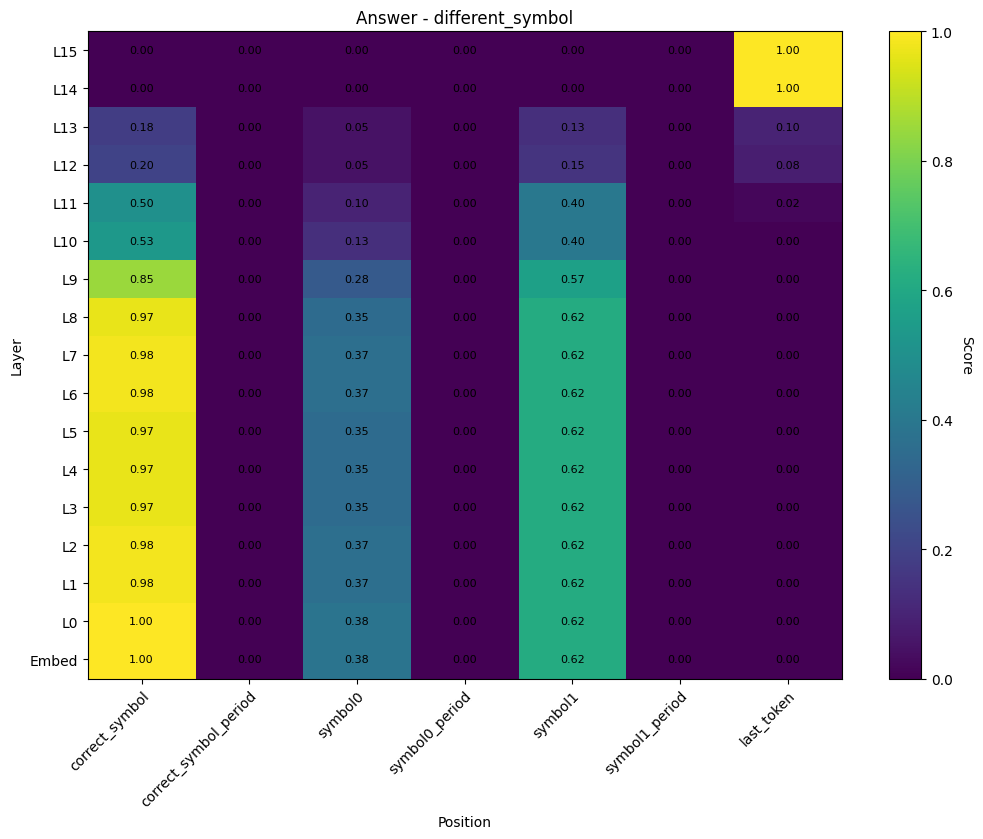

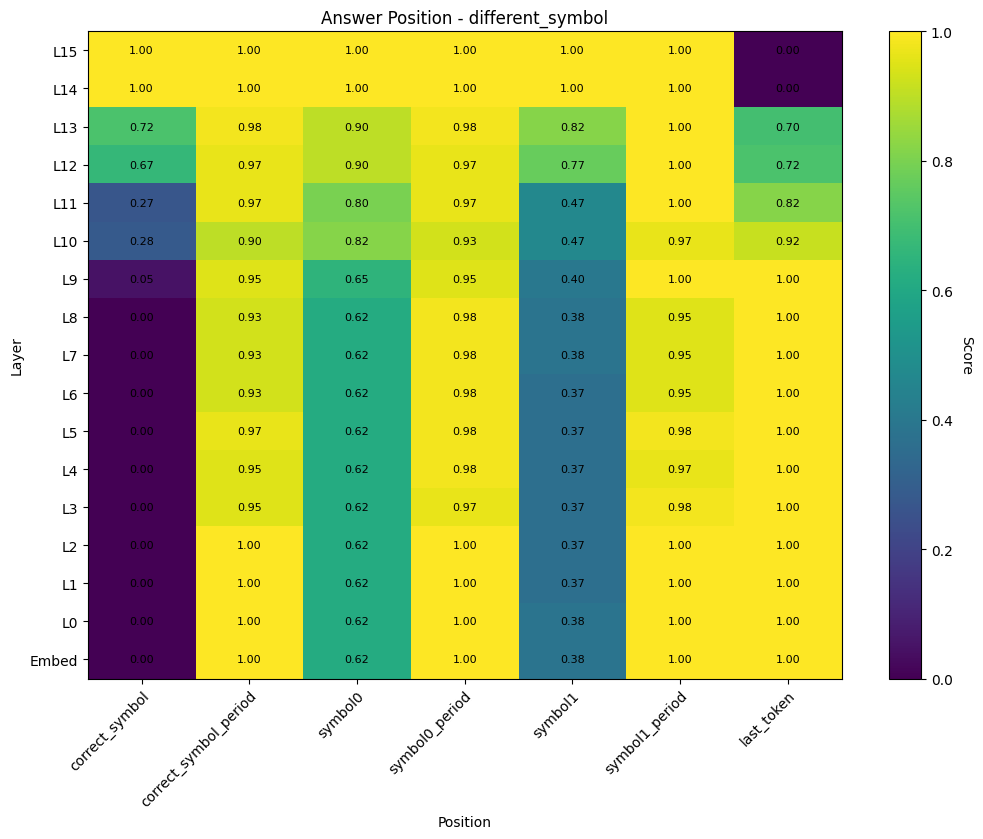

In [7]:
# Check what the causal model can distinguish for answer_position
print(
    causal_model.can_distinguish_with_dataset(
        different_symbol_pairs, ["answer_position"], None
    )
)
print(
    causal_model.can_distinguish_with_dataset(
        different_symbol_pairs, ["answer"], ["answer_position"]
    )
)

patch_dataset("different_symbol")

## Different Symbol Counterfactual Results (Localizing the Answer Position Variable)

Next, we load the counterfactual dataset designed to localize the position of the output variable of the causal model that is then dereferenced to retrieve the actual token.
The original and counterfactual inputs in this dataset have the same output, but that output is stored in different positions.

In [ ]:
print("Original input:")
print(same_symbol_diff_position_pairs[0]["input"]["raw_input"])
print("\nCounterfactual input:")
print(same_symbol_diff_position_pairs[0]["counterfactual_inputs"][0]["raw_input"])

{'input': <causalab.causal.trace.CausalTrace object at 0x16b6b3670>, 'counterfactual_inputs': [<causalab.causal.trace.CausalTrace object at 0x16b6b3640>]}
Original input:
The cup is green. What color is the cup?
M. green
D. pink
Answer:

Counterfactual input:
The cup is green. What color is the cup?
D. pink
M. green
Answer:



This dataset can distinguish the answer position variable from the answer variable and no intervention (see the first notebook for a more extended explanation). 

Observe that the answer position variable has some signal (around 50%) for the first and second symbol positions, however this is due to these interventions resulting in the same symbol occurring twice in context. Half the time, the remaining symbol is the expected output. 

Otherwise, it seems that only a single layer, i.e., layer 11, contains a notable signal for the answer position variable.

In [9]:
# Analysis for same_symbol_different_position dataset
print(
    causal_model.can_distinguish_with_dataset(
        same_symbol_diff_position_pairs, ["answer_position"], None
    )
)
print(
    causal_model.can_distinguish_with_dataset(
        same_symbol_diff_position_pairs, ["answer"], ["answer_position"]
    )
)

{'proportion': 1.0, 'count': 53}
{'proportion': 1.0, 'count': 53}


This dataset confounds the answer variable with no intervention, meaning interchange intervention accuracy on this dataset is perfect when the model output doesn't change.  
This results in all of the causally irrelevant locations in the residual stream lighting up in the heatmap. Furthermore, the single location with the best signal for the answer position variable is dull on the heatmap because that location results in the model behavior changing.

{'proportion': 0.0, 'count': 0}
{'proportion': 1.0, 'count': 53}

Processing dataset: same_symbol_different_position


Running interventions: 100%|██████████| 119/119 [08:14<00:00,  4.15s/it]


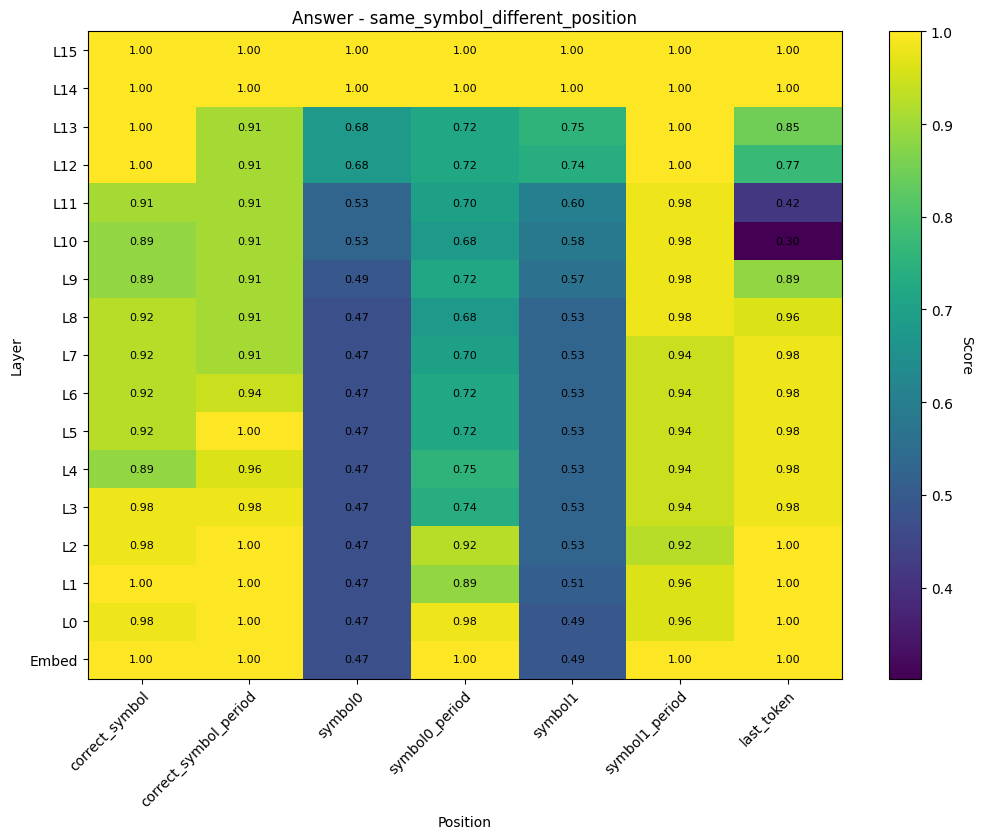

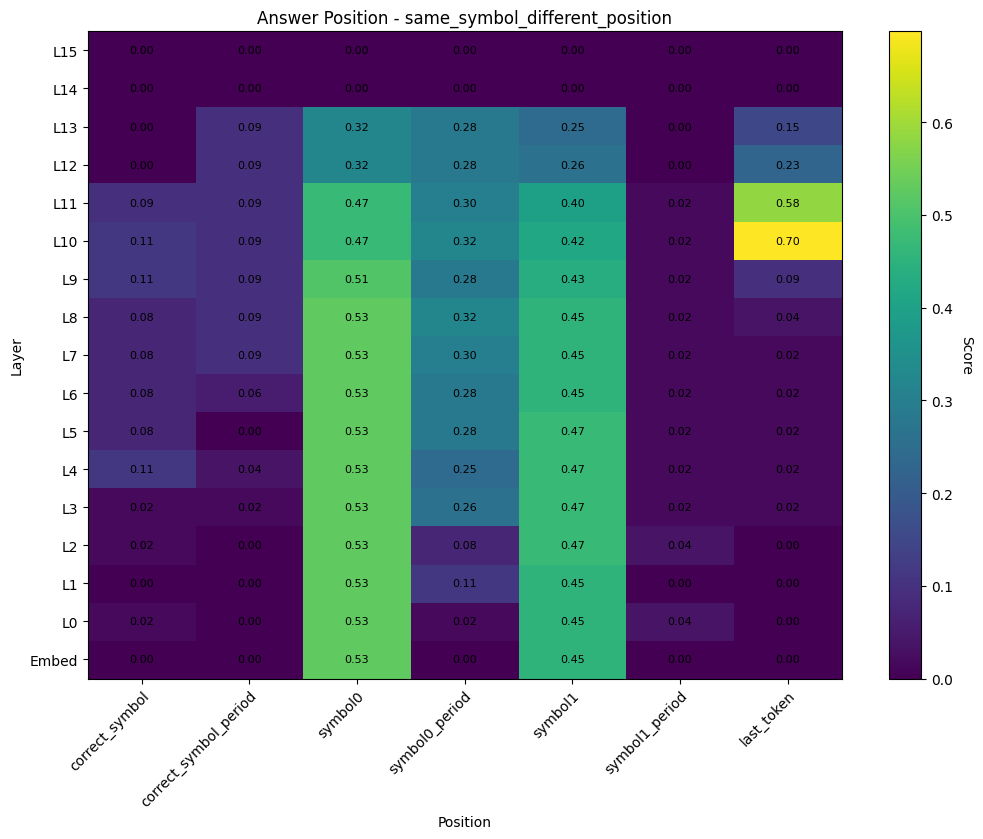

In [10]:
print(
    causal_model.can_distinguish_with_dataset(
        same_symbol_diff_position_pairs, ["answer"], None
    )
)
print(
    causal_model.can_distinguish_with_dataset(
        same_symbol_diff_position_pairs, ["answer"], ["answer_position"]
    )
)

patch_dataset("same_symbol_different_position")

## Random Counterfactual Results

The previous datasets were constructed to easily localize the answer and the answer position variables. However, they only contain counterfactual inputs that match the question and choices of the original input. A random counterfactual will have an entirely new question, choices, and symbols, which makes this an experiment with fully distinct counterfactuals from the other datasets!

In [11]:
print("Original input:")
print(random_pairs[0]["input"]["raw_input"])
print("\nCounterfactual input:")
print(random_pairs[0]["counterfactual_inputs"][0]["raw_input"])

Original input:
The cup is brown. What color is the cup?
W. brown
Q. white
Answer:

Counterfactual input:
The bag is yellow. What color is the bag?
B. blue
T. yellow
Answer:


Localizing the answer position variable with the random counterfactuals is similar to the results with the same_symbol_different_position counterfactuals, because we again see that the residual stream of the last token at layer 11 contains the strongest positional signal. However, because the counterfactuals contain entirely new symbols---instead of the same symbols swapped as is the case for the same_symbol_different_position counterfactuals---the signal above the two symbol tokens is lower.

In [12]:
# Analysis for random_counterfactual dataset - answer_position variable
print(
    causal_model.can_distinguish_with_dataset(random_pairs, ["answer_position"], None)
)
print(
    causal_model.can_distinguish_with_dataset(
        random_pairs, ["answer"], ["answer_position"]
    )
)

{'proportion': 0.5081967213114754, 'count': 31}
{'proportion': 0.9672131147540983, 'count': 59}


Localizing the answer position variable with the random counterfactuals provides similar results to localizing with the different symbol counterfactuals. The main difference is that the signal is more diffuse.

{'proportion': 0.9508196721311475, 'count': 58}
{'proportion': 0.9672131147540983, 'count': 59}

Processing dataset: random_counterfactual


Running interventions: 100%|██████████| 119/119 [09:28<00:00,  4.78s/it]


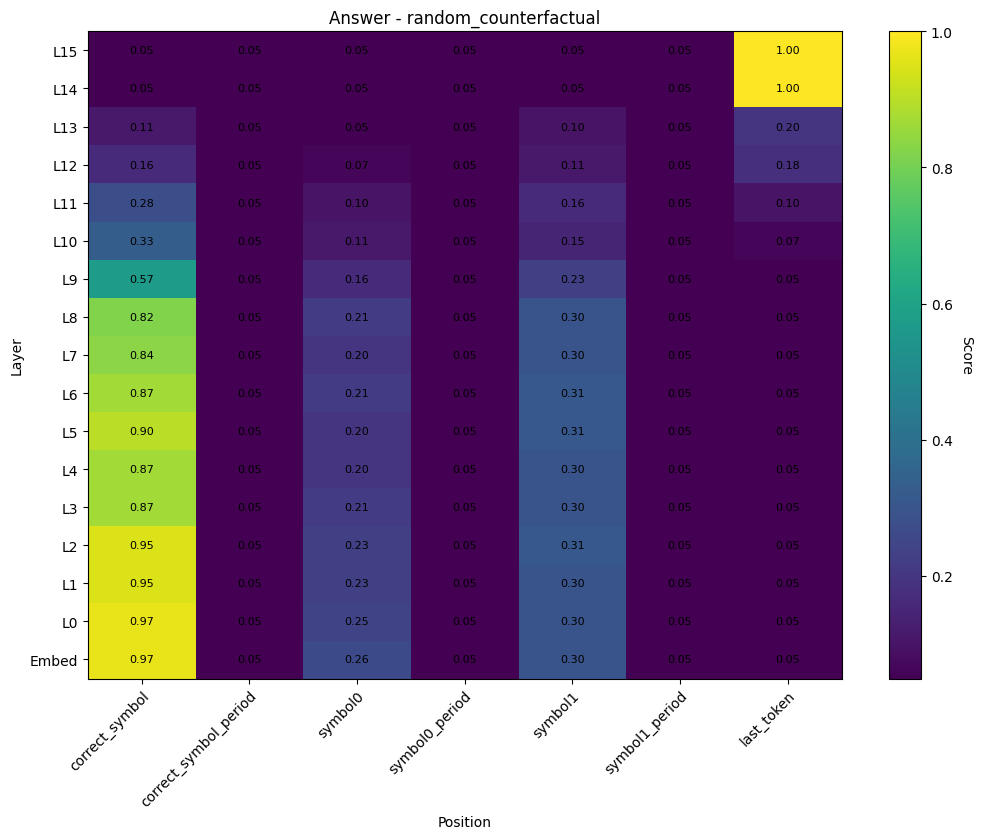

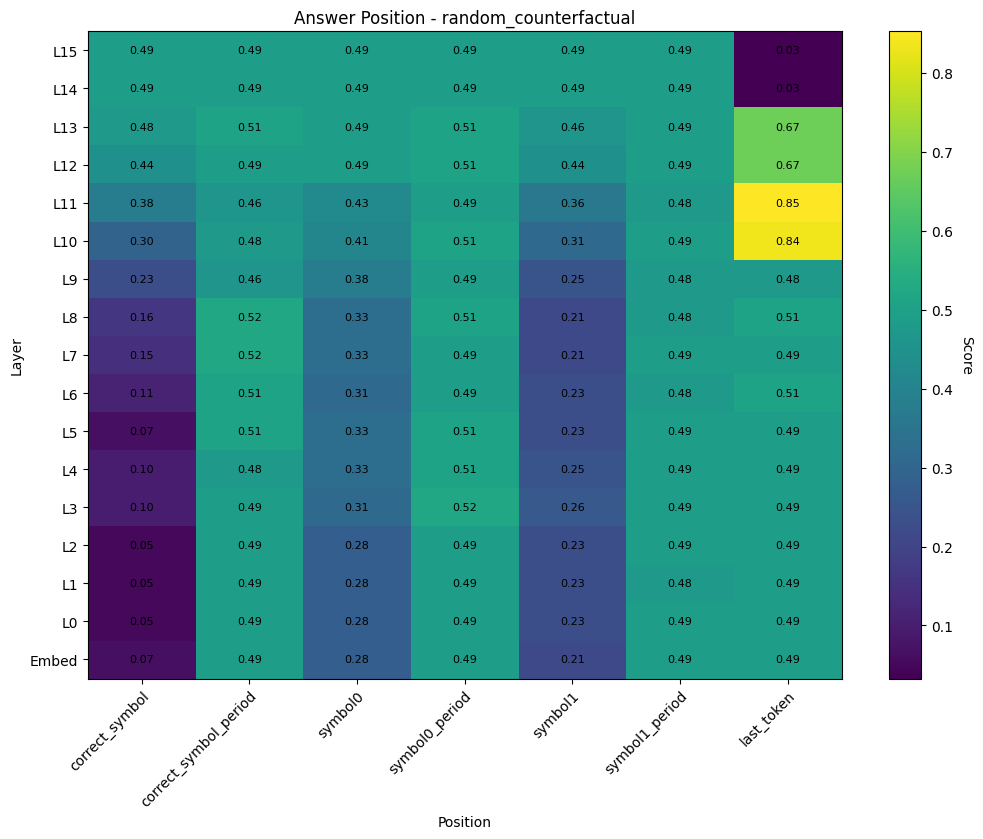

In [13]:
# Analysis for random_counterfactual dataset - answer variable
print(causal_model.can_distinguish_with_dataset(random_pairs, ["answer"], None))
print(
    causal_model.can_distinguish_with_dataset(
        random_pairs, ["answer"], ["answer_position"]
    )
)

patch_dataset("random_counterfactual")

# Takeaway

Intervening on the entire residual stream vector is a crude operation that lacks any precision. However, we can see it is a powerful tool that can immediately give us a quantitative and qualitative impression of how the network processes information to solve a task! We can also see the crucial role of designing counterfactual datasets in testing hypothesized causal abstractions.

No single counterfactual dataset is sufficient to localize causal variables within a neural network. Instead, we should build up a number of diagnostic datasets and precisely quantify their ability to discriminate between hypotheses. If we see surprising results, we can iterate and redesign the causal model or the counterfactual datasets to formulate a new hypothesis.